In [1]:
import os
from pathlib import Path

import geopandas as gpd
import numpy as np
import pandana as pdna
import pandas as pd

In [2]:
data_path = Path(os.environ["DATA_PATH"])
census_path = Path(os.environ["CENSUS_PATH"])
population_grids_path = Path(os.environ["POPULATION_GRIDS_PATH"])
geostatistical_framework_path = Path(os.environ["GEOSTATISTICAL_FRAMEWORK_PATH"])
results_path = Path(os.environ["RESULTS_PATH"])

In [3]:
ADJUSTMENT_FACTOR = 3
WALK_SPEED = 5  # km/h
MAX_DISTANCE = 5_000  # aprox 1 hour of walking
NUM_POIS = 5

EQUIPAMIENTOS = {
    'guarderia': {
        'radius': 750
    },
    'preescolar': {
        'radius': 750
    },
    'primaria': {
        'radius': 500
    },
    'secundaria': {
        'radius': 1_000
    },
    'preparatoria': {
        'radius': 5_000
    },
    'universidad': {
        'radius': 50_000
    },
    'parque': {
        'radius': 670
    },
    'auditorio': {
        'radius': 1_000
    },
    'biblioteca': {
        'radius': 10_000
    },
    'cine': {
        'radius': 1_500
    },
    'unidad_deportiva': {
        'radius': 10_000
    },
    'hospital': {
        'radius': 50_000
    },
    'centro_salud': {
        'radius': 1_000
    },
}

In [4]:
def process_gdf(path: str):
    return (
        gpd.read_file(data_path / path)
        .reset_index(drop=True)
        .filter(["geometry"])
        .to_crs("EPSG:6372")
    )


df_guarderia = process_gdf(
    "datos/Guarderias/Guarderias.shp").assign(equipamiento='guarderia')
df_preescolar = process_gdf(
    "datos/PreescolarWgs84/PreescolarWgs84.shp").assign(equipamiento='preescolar')
df_primaria = process_gdf(
    "datos/PrimariasWgs84/PrimariasWgs84.shp").assign(equipamiento='primaria')
df_secundaria = process_gdf(
    "datos/Secundarias_Wgs84/Secundarias_Wgs84.shp").assign(equipamiento='secundaria')
df_preparatoria = process_gdf(
    "datos/Preparatorias_Wgs84/Preparatorias_Wgs84.shp").assign(equipamiento='preparatoria')
df_universidad = process_gdf(
    "datos/Superior_Wgs84/Superior_Wgs84.shp").assign(equipamiento='universidad')
df_parque = process_gdf(
    "datos/pparquesWgs84/pparquesWgs84.shp").assign(equipamiento='parque')
df_auditorio = process_gdf(
    "datos/Auditorios_Wgs84/Auditorios_Wgs84.shp").assign(equipamiento='auditorio')
df_biblioteca = process_gdf(
    "datos/Bibliotecas/BibliotecasWgs84.shp").assign(equipamiento='biblioteca')
df_cine = process_gdf(
    "datos/cinesWGS84/cinesWGS84.shp").assign(equipamiento='cine')
df_unidad_deportiva = process_gdf(
    "datos/Uni_DeportivasWgs84/Uni_DeportivasWgs84.shp").assign(equipamiento='unidad_deportiva')
gdf_unidad_medica = (
    gpd.read_file(
        data_path / "datos/Unidad_Medica_Wgs84/Unidad_Medica_Wgs84.shp")
    .assign(equipamiento='unidad_medica')
    .reset_index(drop=True)
    .to_crs("EPSG:6372")
)
salud_equipamientos = {
    'CLÍNICA': 'centro_salud',
    'HOSPITAL': 'hospital',
    'CENTRO DE SALUD': 'centro_salud'
}
gdf_unidad_medica = gdf_unidad_medica[(gdf_unidad_medica['CATEGORIA'] == 'PÚBLICO') & (
    gdf_unidad_medica['TIPO'].isin(salud_equipamientos.keys()))]
gdf_unidad_medica['equipamiento'] = gdf_unidad_medica['TIPO'].map(
    salud_equipamientos)
gdf_unidad_medica = gdf_unidad_medica.filter(['geometry', 'equipamiento'])

df_equipamientos = pd.concat([df_guarderia, df_preescolar, df_primaria, df_secundaria, df_preparatoria,
                             df_universidad, df_parque, df_auditorio, df_biblioteca, df_cine, df_unidad_deportiva, gdf_unidad_medica])
df_equipamientos['capacity'] = 1
df_equipamientos = gpd.GeoDataFrame(
    df_equipamientos, geometry='geometry', crs='EPSG:6372')
df_equipamientos['geometry'] = df_equipamientos.centroid
df_equipamientos.head()

,geometry,equipamiento,capacity
0,POINT (2078072.038 2189348.874),guarderia,1
1,POINT (2083880.276 2181248.302),guarderia,1
2,POINT (2085036.549 2181192.865),guarderia,1
3,POINT (2081444.276 2181347.528),guarderia,1
4,POINT (2080421.538 2182165.071),guarderia,1


In [5]:
df_census_base = pd.read_csv(
    census_path / "2020" / "08.csv",
    usecols=[
        "ENTIDAD",
        "MUN",
        "LOC",
        "AGEB",
        "MZA",
        "NOM_LOC",
        "POBTOT",
        "P_0A2",
        "P_3A5",
        "P_60YMAS",
        "P18YM_PB",
        "P_18YMAS",
        "GRAPROES",
        "TVIVPARHAB",
        "PRO_OCUP_C",
        "VPH_PISODT",
        "VPH_C_ELEC",
        "VPH_REFRI",
        "VPH_LAVAD",
        "VPH_HMICRO",
        "VPH_NDACMM",
    ],
)

In [6]:
df_geom_agebs = (
    gpd.read_file(
        population_grids_path
        / "08.2.03.gpkg",
    )
    .drop(columns=["POBTOT"])
    .rename(columns={"CVEGEO": "id"})
    .set_index("id")
)

df_census_agebs = (
    df_census_base.query("NOM_LOC == 'Total AGEB urbana'")
    .assign(
        CVEGEO=lambda df: (
            df["ENTIDAD"].astype(str).str.zfill(2)
            + df["MUN"].astype(str).str.zfill(3)
            + df["LOC"].astype(str).str.zfill(4)
            + df["AGEB"].astype(str).str.zfill(4)
        ),
    )
    .drop(columns=["ENTIDAD", "MUN", "LOC", "AGEB", "NOM_LOC"])
    .set_index("CVEGEO")
    .replace("*", np.nan)
    .astype(float)
)

df = df_geom_agebs.join(df_census_agebs, how="inner")

In [7]:
df_geom_blocks = (
    gpd.read_file(geostatistical_framework_path /
                  "2020" / "08_chihuahua" / "08m.shp")
    .assign(CVEGEO_AGEB=lambda x: x.CVEGEO.str[:13])
    .query("CVEGEO_AGEB in @df_geom_agebs.index")
    .set_index("CVEGEO")
    .to_crs("EPSG:6372")
)


df_census_blocks = (
    df_census_base.assign(
        CVEGEO=lambda df: (
            df["ENTIDAD"].astype(str).str.zfill(2)
            + df["MUN"].astype(str).str.zfill(3)
            + df["LOC"].astype(str).str.zfill(4)
            + df["AGEB"].astype(str).str.zfill(4)
            + df["MZA"].astype(str).str.zfill(3)
        ),
    )
    .drop(columns=["ENTIDAD", "MUN", "LOC", "AGEB", "MZA", "NOM_LOC"])
    .set_index("CVEGEO")
    .replace(["*", "N/D"], np.nan)
    .astype(float)
)

df_blocks = df_geom_blocks.join(df_census_blocks, how="inner")

In [8]:
def create_network():
    gdf_vialidades = gpd.read_file(
        "data/NAD/datos/Vialidad/VialidadWgs84.shp").to_crs("EPSG:6372")
    gdf_edges = gdf_vialidades.explode(index_parts=False)

    gdf_edges["u_geom"] = gdf_edges.geometry.apply(lambda geom: geom.coords[0])
    gdf_edges["v_geom"] = gdf_edges.geometry.apply(
        lambda geom: geom.coords[-1])

    gdf_nodes = pd.DataFrame(
        pd.concat([gdf_edges["u_geom"], gdf_edges["v_geom"]])
        .drop_duplicates()
        .tolist(),
        columns=["x", "y"]
    ).reset_index(drop=True)
    gdf_nodes["node_id"] = gdf_nodes.index

    coord_to_id = {
        (row.x, row.y): row.node_id for row in gdf_nodes.itertuples(index=False)}
    gdf_edges["u"] = gdf_edges["u_geom"].map(coord_to_id)
    gdf_edges["v"] = gdf_edges["v_geom"].map(coord_to_id)

    gdf_edges["distance"] = gdf_edges.geometry.length
    gdf_edges = gdf_edges[["u", "v", "distance"]].reset_index(drop=True)
    gdf_nodes = gdf_nodes[["node_id", "x", "y"]]

    net = pdna.Network(
        gdf_nodes["x"],
        gdf_nodes["y"],
        gdf_edges["u"],
        gdf_edges["v"],
        gdf_edges[["distance"]],
    )
    net.precompute(MAX_DISTANCE)
    net.save_hdf5(results_path / "network.h5")
    return net

In [9]:
if not os.path.exists(results_path / "network.h5"):
    net = create_network()
else:
    net = pdna.Network.from_hdf5(results_path / "network.h5")

Generating contraction hierarchies with 1 threads.
Setting CH node vector of size 59222
Setting CH edge vector of size 82175
Range graph removed 174 edges of 164350
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [10]:
def get_proximities(
    net: pdna.Network,
    coords: pd.DataFrame,
    poi_type: str,
    max_distance: float,
    num_pois: int = 1,
) -> pd.Series:
    net.set_pois(poi_type, max_distance, num_pois, coords["x"], coords["y"])
    res = (
        net.nearest_pois(
            distance=max_distance,
            category=poi_type,
            num_pois=num_pois,
            include_poi_ids=True,
        )
        .rename(columns={x: f"distance{x}" for x in range(1, num_pois + 1)})
        .reset_index(names="origin_id")
    )
    return (
        pd.wide_to_long(
            res,
            stubnames=["distance", "poi"],
            i="origin_id",
            j="num_poi",
            sep="",
        )
        .rename(columns={"poi": "destination_id"})
    )

In [11]:
coords = df_blocks.centroid.get_coordinates()
df_blocks["origin_id"] = net.get_node_ids(coords["x"], coords["y"])
df_blocks = df_blocks.reset_index().set_index('origin_id')

In [12]:
def get_accessibility_metrics(
        net: pdna.Network,
        destinations: gpd.GeoDataFrame,
        weights: pd.Series,
        amenity: str,
        max_distance: float,
        num_pois: int,
        walk_speed: float,
        radius: float,
        adjustment_factor: float
):
    proximities = get_proximities(
        net,
        destinations.get_coordinates(),
        amenity,
        max_distance=max_distance,
        num_pois=num_pois,
    )
    proximities['time'] = (
        proximities['distance'] / 1000) * 60 / walk_speed
    proximities = proximities.join(weights, on="origin_id")
    proximities = proximities.join(
        destinations[['capacity']], on="destination_id")
    proximities['gravity'] = 1 / \
        np.exp(1 / (radius / adjustment_factor) *
               proximities['distance'])
    proximities['reach'] = proximities['gravity'] * \
        proximities[weights.name]
    destinations = (
        proximities.groupby("destination_id")
        .agg({"reach": "sum", "capacity": "first"})
        .assign(
            opportunities_ratio=lambda df: df.apply(
                lambda x: x["capacity"] / x["reach"] if x["reach"] > 0 else 0,
                axis=1,
            ),
        )
        .query("opportunities_ratio > 0")
    )
    proximities["accessibility_score"] = proximities.apply(
        lambda x: destinations["opportunities_ratio"].loc[x["destination_id"]]
        * x["gravity"]
        if x["destination_id"] in destinations["opportunities_ratio"].index
        else 0,
        axis=1,
    )
    accessibility_scores = (
        proximities.reset_index().groupby(["origin_id", "destination_id"])
        .agg({"accessibility_score": "sum", "time": "min"})
        .groupby("origin_id")
        .agg({"accessibility_score": "sum", "time": "max"})
    )
    return accessibility_scores

In [13]:
scores = pd.DataFrame()
for nombre, item in EQUIPAMIENTOS.items():
    print(nombre)
    df_temp = df_equipamientos[df_equipamientos['equipamiento'] == nombre]
    accessibility_scores = get_accessibility_metrics(
        net, df_temp, df_blocks['POBTOT'], nombre, MAX_DISTANCE, NUM_POIS, WALK_SPEED, item['radius'], ADJUSTMENT_FACTOR)
    accessibility_scores['category'] = nombre
    scores = pd.concat([scores, accessibility_scores])

guarderia
preescolar
primaria
secundaria
preparatoria
universidad
parque
auditorio
biblioteca
cine
unidad_deportiva
hospital
centro_salud


In [14]:
final_score = (
    scores.groupby('origin_id')
    .agg({'accessibility_score': 'sum'})
)
results = df_blocks.join(
    final_score, on="origin_id")
df_blocks['accessibility_score'] = results['accessibility_score']

Q1 = df_blocks['accessibility_score'].quantile(0)
Q3 = df_blocks['accessibility_score'].quantile(0.9)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_blocks['accessibility_score'] = df_blocks['accessibility_score'].clip(
    lower_bound, upper_bound)
df_blocks['accessibility_score'] = (df_blocks['accessibility_score'] - df_blocks['accessibility_score'].min()) / (
    df_blocks['accessibility_score'].max() - df_blocks['accessibility_score'].min())

array([[<Axes: title={'center': 'accessibility_score'}>]], dtype=object)

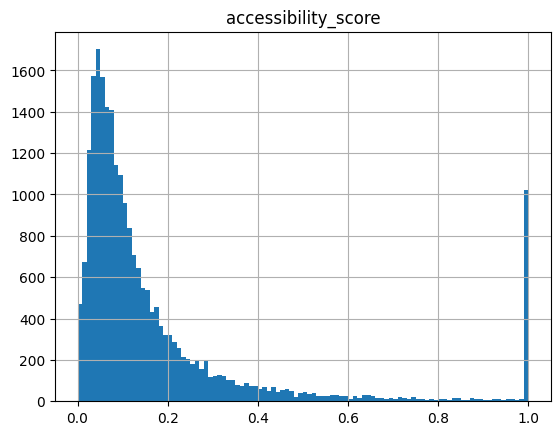

In [15]:
df_blocks.hist(column="accessibility_score", bins=100, range=(0, 1))

<Axes: >

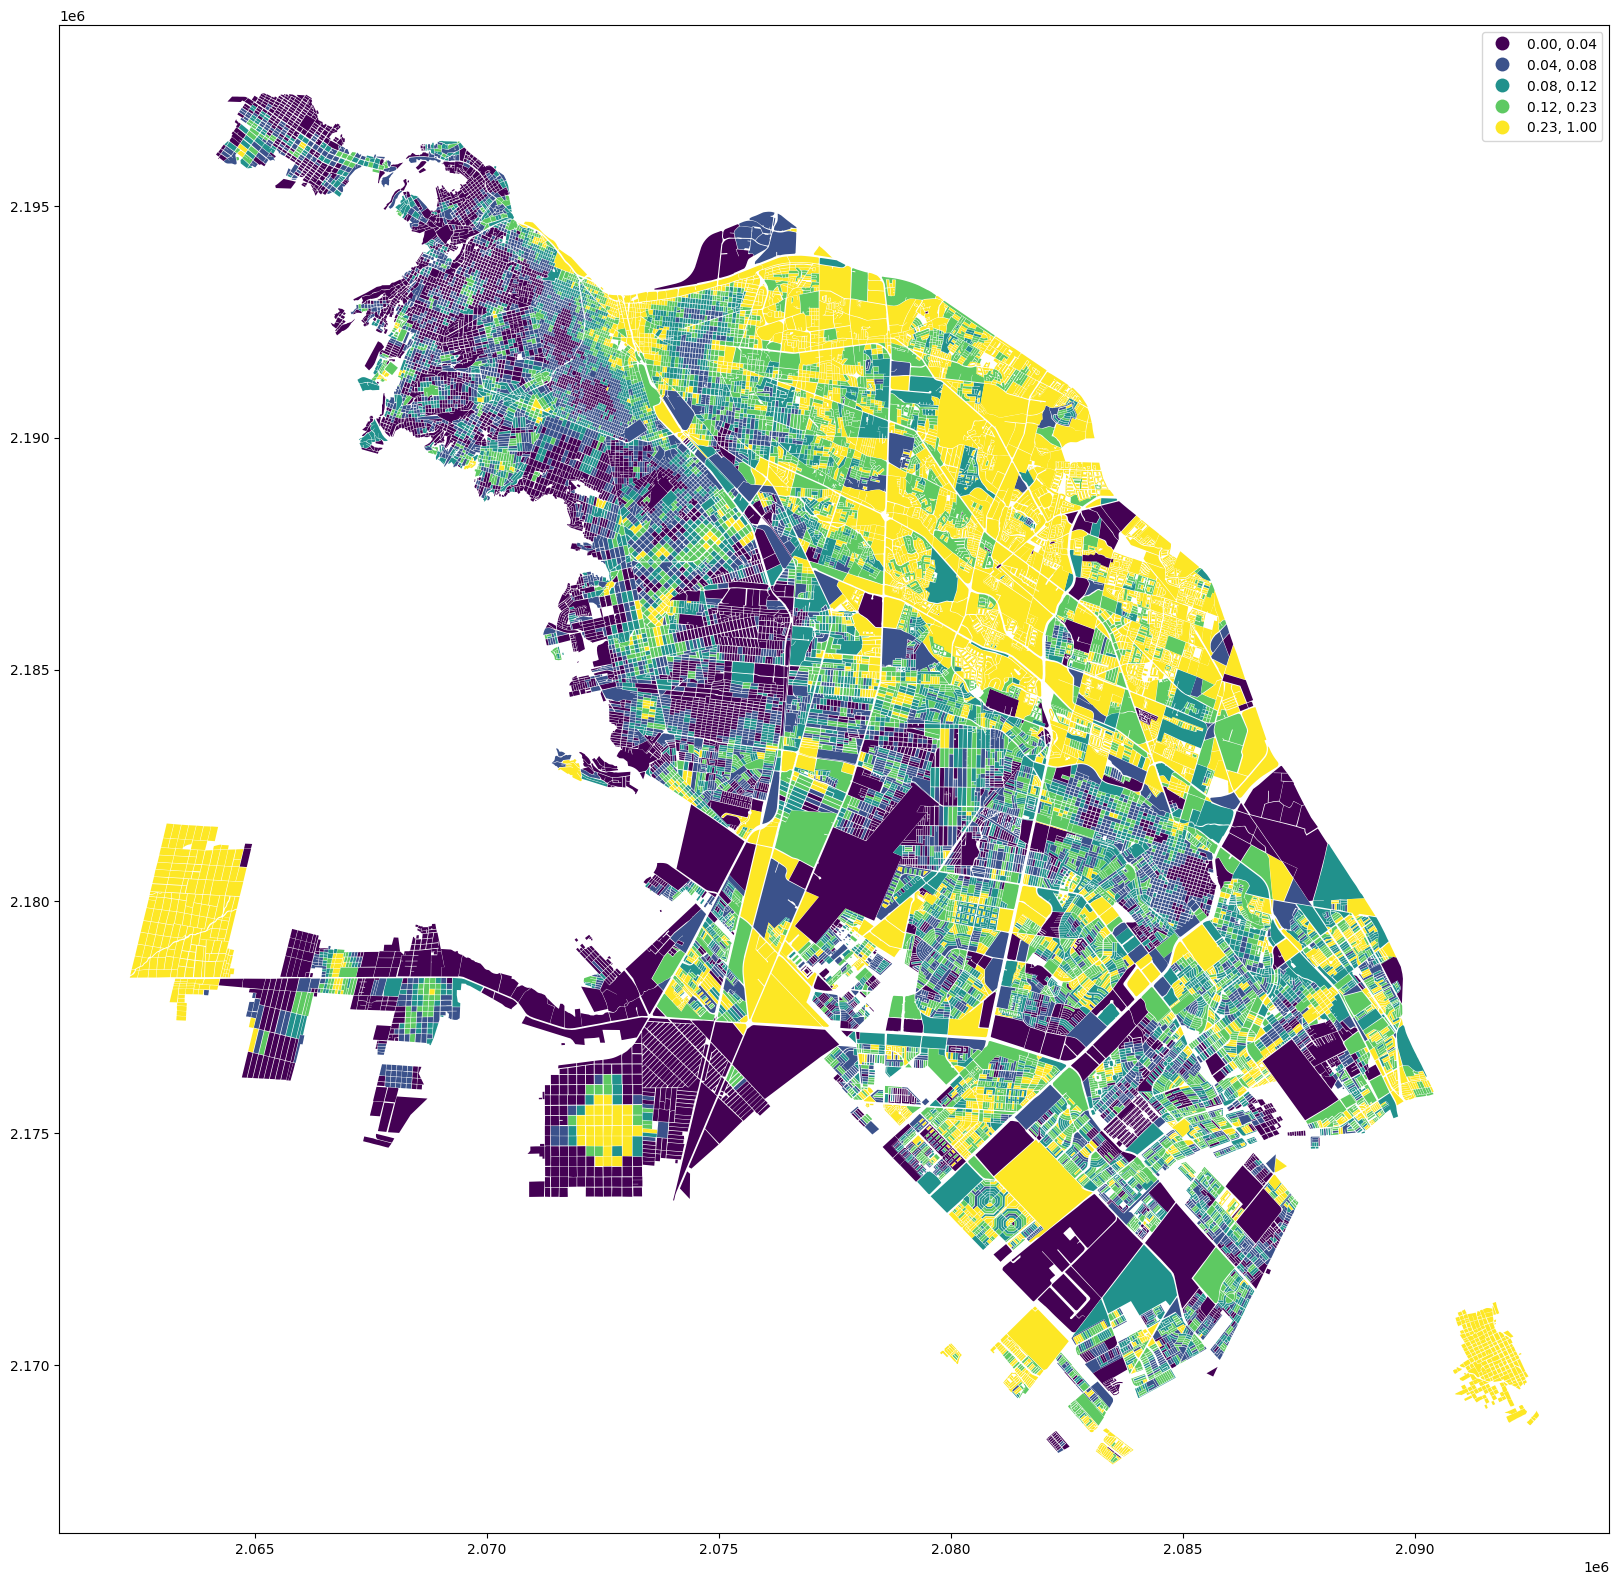

In [16]:
df_blocks.plot(column="accessibility_score", scheme="quantiles", k=5, legend=True, figsize=(20, 20))

In [17]:
df_agebs = df_blocks.reset_index().set_index('CVEGEO').groupby('CVEGEO_AGEB').agg({'accessibility_score': 'mean', 'geometry': 'first'})
df_geom_agebs = df_geom_agebs.join(df_agebs.drop(columns=['geometry']))

<Axes: >

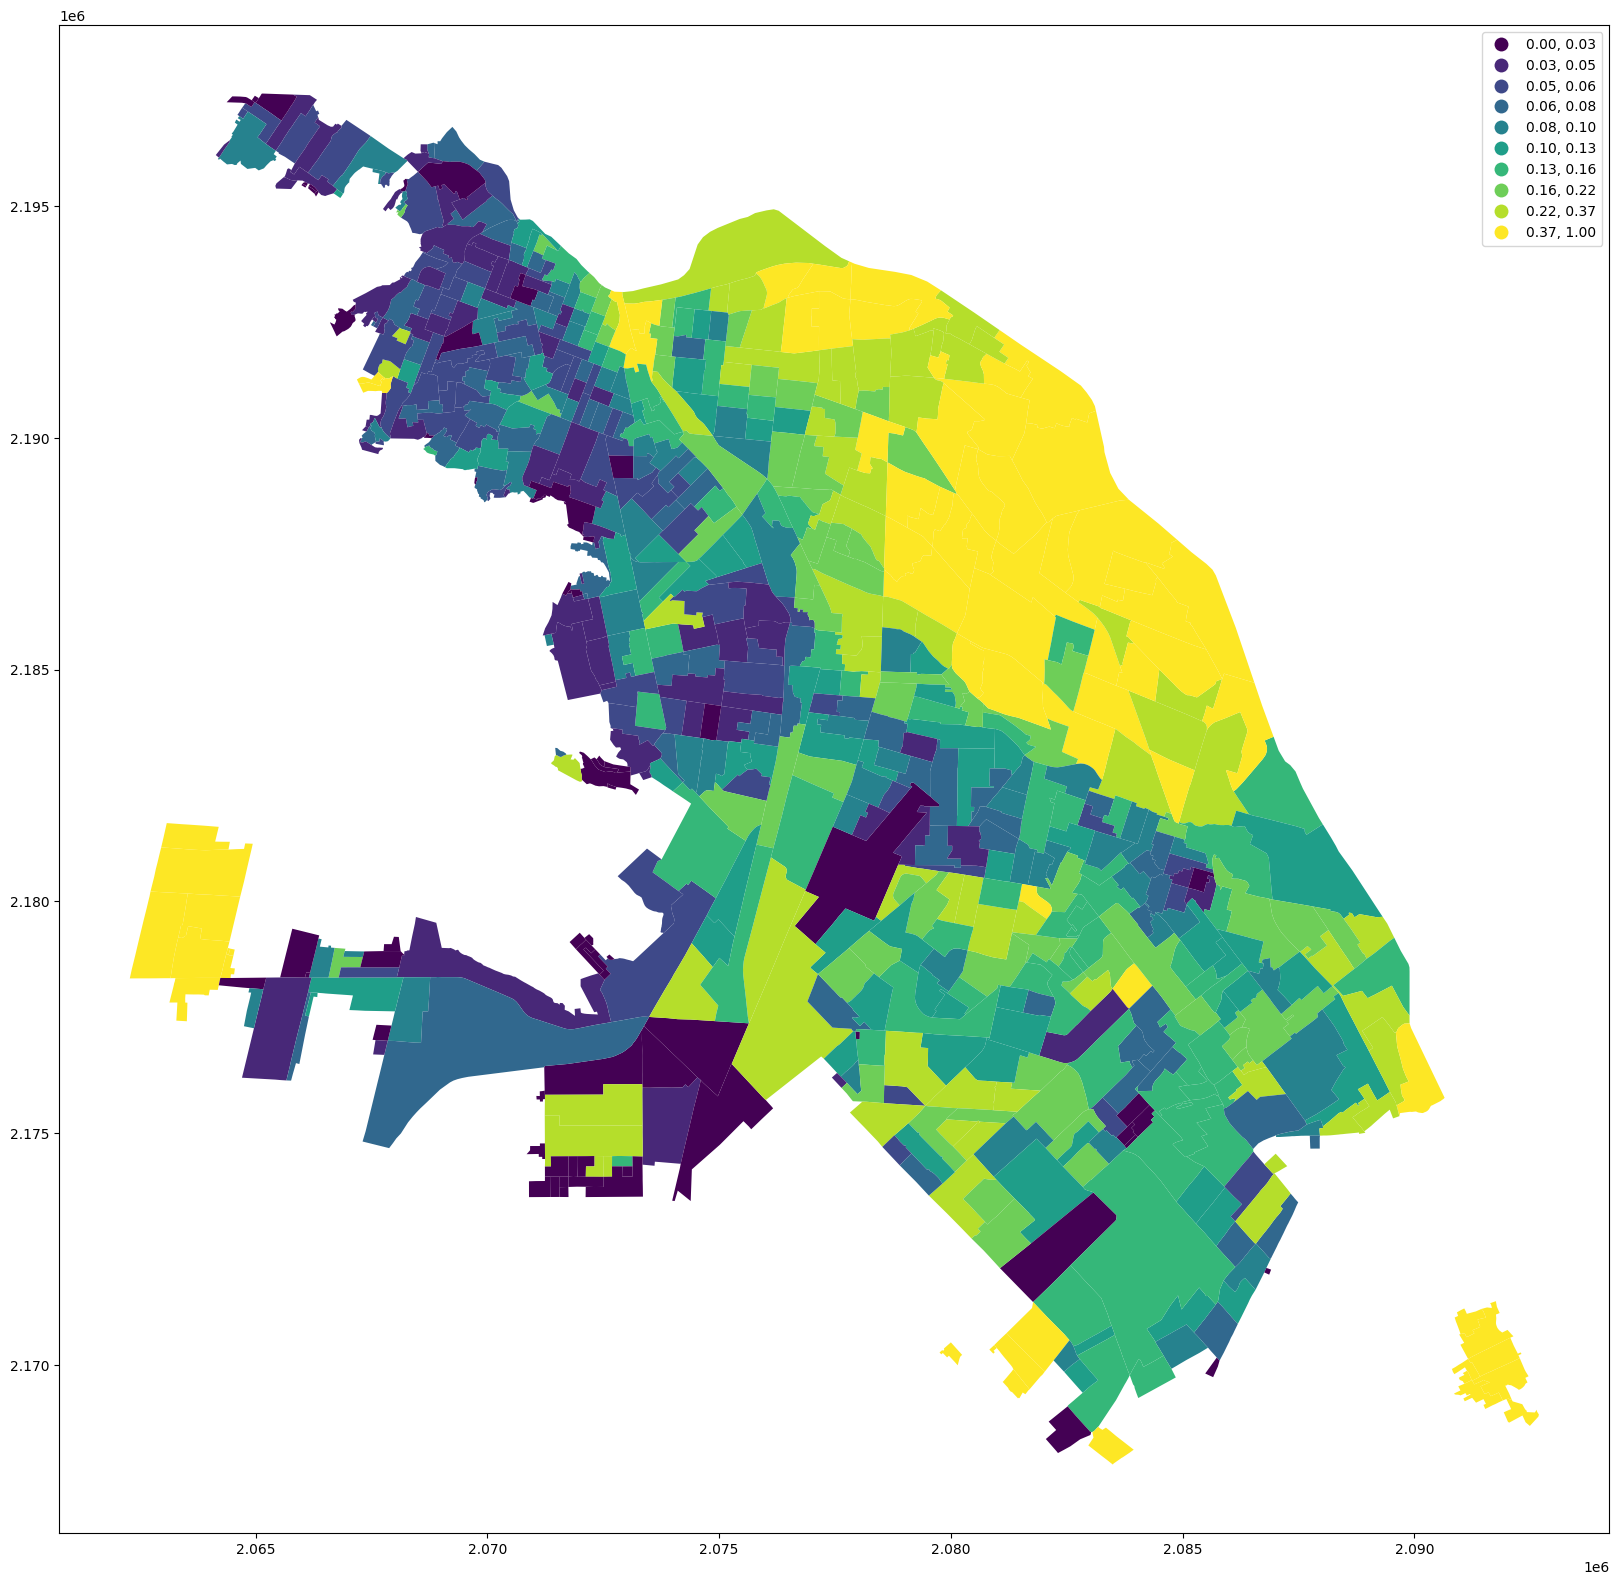

In [18]:
df_geom_agebs.plot(column='accessibility_score', scheme='quantiles', k=10, legend=True, figsize=(20, 20))

<Axes: >

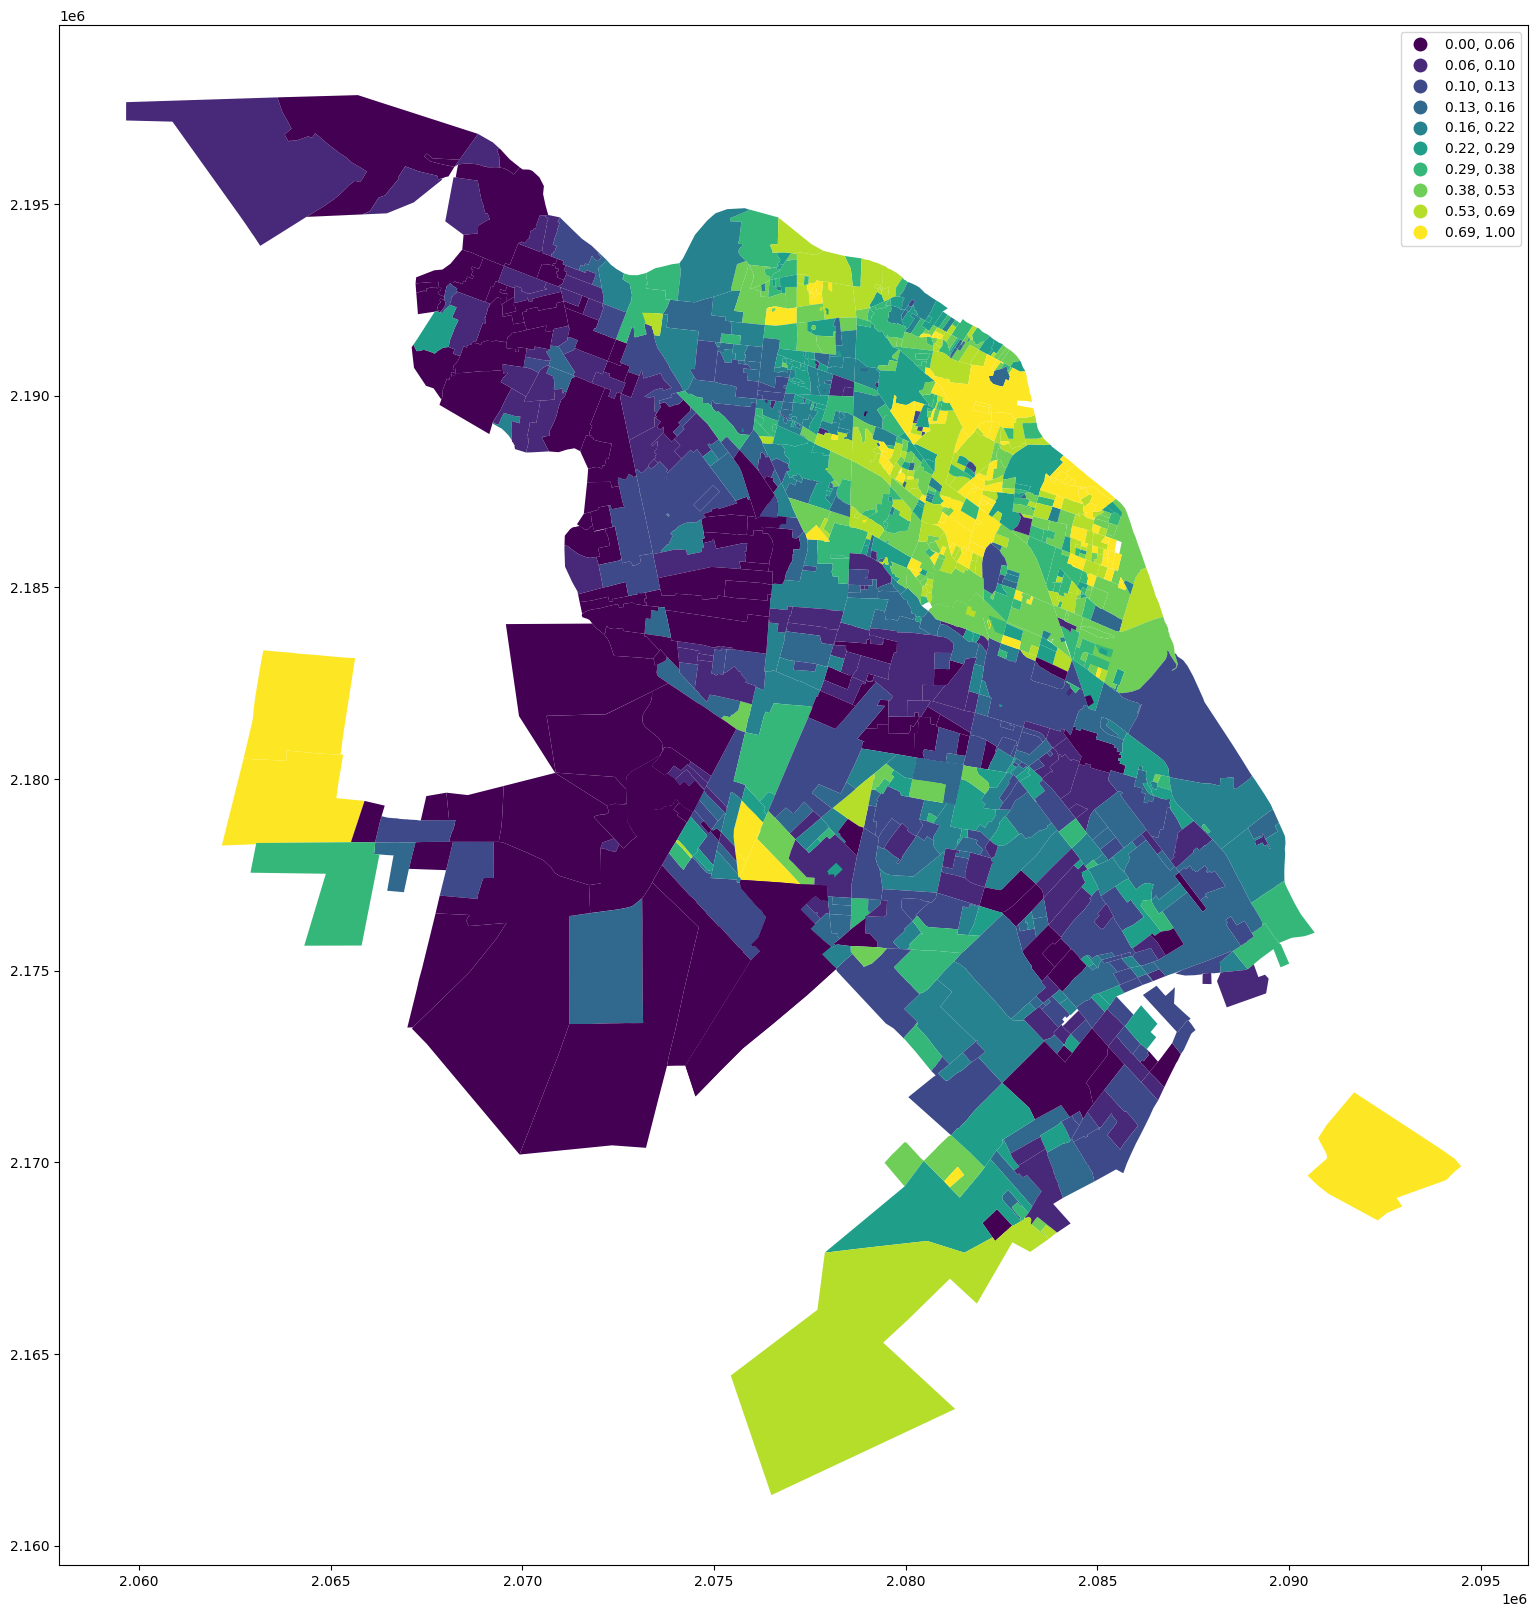

In [19]:
df_colonias = gpd.read_file(
    "data/NAD/datos/colonias.geojson").to_crs("EPSG:6372")
df_colonias = df_colonias.sjoin(df_blocks, how='left')
df_colonias = df_colonias.groupby('ID').agg(
    {'accessibility_score': 'mean', 'geometry': 'first'})
df_colonias = gpd.GeoDataFrame(
    df_colonias, geometry='geometry', crs='EPSG:6372')
df_colonias.plot(column='accessibility_score',
                 scheme='quantiles', k=10, legend=True, figsize=(20, 20))

In [20]:
df_geom_agebs[['accessibility_score']].reset_index().to_csv(
    results_path / "accessibility_agebs.csv")
df_colonias[['accessibility_score']].reset_index().to_csv(
    results_path / "accessibility_colonias.csv")